In [74]:
using Distributed
using JLD
using LsqFit
using StatsBase
using Statistics
using Query
using Random
# @everywhere using Statistics
include("/nfshome/hshapourian/GaussianTNS/Code/RTN.jl")
using DataFrames
using PyPlot
@everywhere using Statistics

In [75]:
function hopp_vec(Mx,My,vec,px,py)
    # generates hoping matrix on square lattice
    # vec= hopping vector
    # py=1 PBC along y otherwise OBC
    # px=1 PBC along x otherwise OBC
    
    hopin=im*zeros(Mx*My,Mx*My)
    for i_y=0: (My-1)
        for i_x in 0: (Mx-1)
            i_px=i_x+vec[1]
            i_py=i_y+vec[2]
            if ((i_px>=Mx) || (i_px<0)) && (i_py< My) && (i_py>=0)
                if i_px>=Mx 
                    hx=px
                else
                    hx=conj(px)
                end
                i_px=i_px%Mx
                hopin[1+i_px+i_py*Mx,1+i_x+i_y*Mx]=hx
            elseif ((i_py>=My) || (i_py<0)) && (i_px< Mx) && (i_px>=0)
                if i_py>=My 
                    hy=py
                else
                    hy=conj(py)
                end
                i_py=i_py%My
#                 println(i_px," ",i_py)
                hopin[1+i_px+i_py*Mx,1+i_x+i_y*Mx]=hy
                    
            elseif ((i_px>=Mx) || (i_px<0)) && ((i_py>=My) || (i_py<0))
                if i_px>=Mx
                    hx=px
                else
                    hx=conj(px)
                end
                if i_py>=My
                    hy=py
                else
                    hy=conj(py)
                end
                i_px=mod(i_px,Mx)
                i_py=mod(i_py,My)
#                 print(i_px, " ")
                hopin[1+i_px+i_py*Mx,1+i_x+i_y*Mx]=hx*hy
                
            elseif (i_px>=0) && (i_px<Mx) && (i_py>=0) && (i_py<My) 
                hopin[1+i_px+i_py*Mx,1+i_x+i_y*Mx]=1
            end
        end
    end                   
    return hopin
end

function measure_onsite(psi,ind1,ind2,occ=0,amp_show=false)
    ## measurement circuit
    
    t_names = map(s -> Meta.parse(s), ["d", "u"])
    Te = BlockMatrix(t_names, [2,2])
    Te[t_names[1],t_names[1]] = [0.0 -1.0;1.0 0.0]
    Te[t_names[2],t_names[2]] = [0.0 1.0;-1.0 0.0]

    To = BlockMatrix(t_names, [2,2])
    To[t_names[1],t_names[1]] = [0.0 1.0;-1.0 0.0]
    To[t_names[2],t_names[2]] = [0.0 -1.0;1.0 0.0]

    T_contract = [Meta.parse("d")]
    
    fparity = 0 
    for k=ind1:ind2    
        psi_contract = [Meta.parse("idx$k")]
        if occ==0
            if amp_show
                psi, amp = schurContract_wPrefactor(psi, To, psi_contract, T_contract)
                println(amp)
            else
                psi = schurContract(psi, To, psi_contract, T_contract)
            end        
        elseif occ==1
            if amp_show
                psi, amp = schurContract_wPrefactor(psi, Te, psi_contract, T_contract)
                println(amp)
            else
                psi = schurContract(psi, Te, psi_contract, T_contract)
            end
        else
#             _ , amp = schurContract_wPrefactor(psi, Te, psi_contract, T_contract)
            amp = (1+psi[psi_contract,psi_contract][1,2])/2
#             println((amp-p2)>1e-7)
            if rand() < abs(amp)
                psi = schurContract(psi, Te, psi_contract, T_contract)
                fparity += 1
            else
                psi = schurContract(psi, To, psi_contract, T_contract)
            end    
        end
        rename!(psi, Meta.parse("u"), Meta.parse("idx$k"))
    end
    psi.M = (psi.M-psi.M')/2
#     psi.M = purify(psi.M)
    return psi, fparity#(fparity%2)
end



measure_onsite (generic function with 3 methods)

In [42]:
t = 1
Δ = 0.5
Lx = 8
Ly = 32
N = Lx*Ly
px= 1
py= 1

χ = 2 
i_names = map(i -> Meta.parse("idx$i"), 1:N)
i_sizes = fill(χ, N)
psi = BlockMatrix(i_names, i_sizes)

fparity = 0
l1 = Lx*div(Ly,4)
l2 = l1
dist = Lx*div(Ly,4)
# mlist = LinRange(0,8Δ,12)
mlist = [0.0]

Nrep = 10
LN= zeros(length(mlist))
LN0= zeros(length(mlist))
LN1= zeros(length(mlist))
LN2= zeros(length(mlist),Nrep)
LN3= zeros(length(mlist),Nrep)
MI= zeros(length(mlist))
MI0= zeros(length(mlist))
MI1= zeros(length(mlist))
MI2= zeros(length(mlist),Nrep)
MI3= zeros(length(mlist),Nrep)

x_sign=diagm(0=> (-1).^mod.(0:Lx*Ly-1,Lx))
y_sign=diagm(0=> (-1).^div.((0:Lx*Ly-1),Lx))

H_x= t* y_sign*hopp_vec(Lx,Ly,[1,0],px,py)
H_y= t* hopp_vec(Lx,Ly,[0,1],px,py)
H_xy_nn=-im*Δ* y_sign*hopp_vec(Lx,Ly,[1,1],px,py)
H_Mxy_nn=im*Δ* y_sign*hopp_vec(Lx,Ly,[-1,1],px,py)
Hhop = H_x+H_y+H_xy_nn+H_Mxy_nn
Hhop = Hhop+ Hhop'

n_occ = zeros(Nrep)
for i_n=1:length(mlist)
    m = mlist[i_n]
    println(i_n)
    H = Hhop + m*y_sign*x_sign

    evals,evecs = eigen(H)
    Cmat = evecs[:,1:div(N,2)]  * evecs[:,1:div(N,2)]'
    CmatT = transpose(Cmat)
#     Gmat= kron(eye(N)- 2*Cmat,[0 1.0; 0 0])- kron(eye(N) -2*Cmat,[0 0; 1.0 0])
    Gmat = kron(I- Cmat-CmatT,[0 1.0;-1.0 0])+ im*kron(Cmat-CmatT,[1.0 0;0 1.0])

    psi[i_names,i_names] = real(Gmat)
    
    MI[i_n] = mutual_information(psi, i_names[1:l1], i_names[l1+dist+1:l1+l2+dist])
    LN[i_n] = logneg_of_sites(psi, i_names[1:l1], i_names[l1+dist+1:l1+l2+dist])

    s1=0
#     psi0 = measure(psi,s1+l1+1,s1+l1+dist,0)
#     LN0[i_n] = logneg_of_sites(psi0, i_names[s1+1:s1+l1], i_names[s1+l1+dist+1:s1+l1+l2+dist])
#     MI0[i_n] = mutual_information(psi0, i_names[s1+1:s1+l1], i_names[s1+l1+dist+1:s1+l1+l2+dist])

#     psi1 = measure(psi,s1+l1+1,s1+l1+dist,1)
#     LN1[i_n] = logneg_of_sites(psi1, i_names[s1+1:s1+l1], i_names[s1+l1+dist+1:s1+l1+l2+dist])
#     MI1[i_n] = mutual_information(psi1, i_names[s1+1:s1+l1], i_names[s1+l1+dist+1:s1+l1+l2+dist])

    for i_r= 1:Nrep
        psi3, f3 = measure_onsite(psi,s1+l1+1,s1+l1+dist,2)
#         while f3!=fparity
#             psi3, f3 = measure_onsite(psi,s1+l1+1,s1+l1+dist,2)
#         end
        n_occ[i_r]= f3
        LN3[i_n,i_r] = logneg_of_sites(psi3, i_names[s1+1:s1+l1], i_names[s1+l1+dist+1:s1+l1+l2+dist])
        MI3[i_n,i_r] = mutual_information(psi3, i_names[s1+1:s1+l1], i_names[s1+l1+dist+1:s1+l1+l2+dist])
        
#         psi2 = measure(psi,s1+l1+1,s1+l1+dist,2)
#         LN2[i_n,i_r] = logneg_of_sites(psi2, i_names[s1+1:s1+l1], i_names[s1+l1+dist+1:s1+l1+l2+dist])
#         MI2[i_n,i_r] = mutual_information(psi2, i_names[s1+1:s1+l1], i_names[s1+l1+dist+1:s1+l1+l2+dist])
    end
end

1


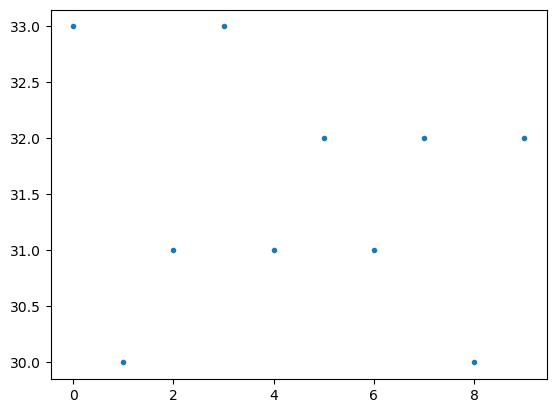

[0.04188731290415532]

In [43]:
plot(n_occ,".")
print(mean(LN3/log(2),dims=2)/Lx)

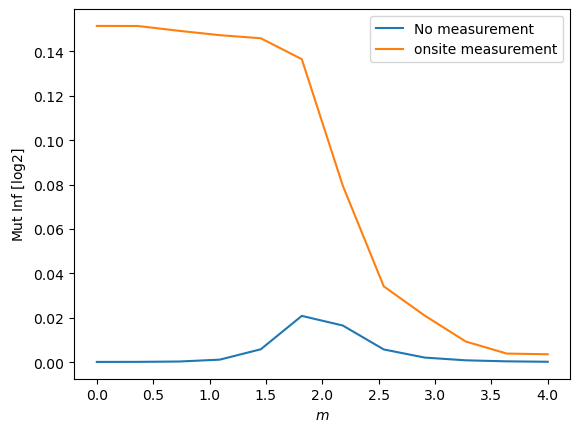

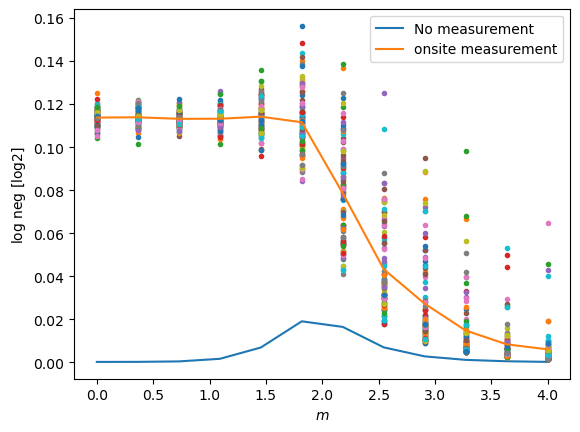

PyObject Text(0.5, 24.0, '$ m $')

In [32]:
plot(mlist,MI/log(2)/Lx,label="No measurement")
# plot(mlist,mean(MI2,dims=2)/log(2),label="link measurement")
plot(mlist,mean(MI3,dims=2)/log(2)/Lx,label="onsite measurement")

legend()
ylabel("Mut Inf \$ [\\log 2 ]\$")
xlabel("\$ m \$")

# plt.savefig("MI_vs_delta_64_32_32.pdf")
plt.show()

plt.figure()
plot(mlist,LN/log(2)/Lx,label="No measurement")
# plot(mlist,mean(LN2,dims=2)/log(2),label="link measurement")
plot(mlist,LN3/log(2)/Lx,".")
plot(mlist,mean(LN3,dims=2)/log(2)/Lx,label="onsite measurement")
# grid()

legend()
ylabel("log neg \$ [\\log 2 ]\$")
xlabel("\$ m \$")

# plt.savefig("SSH_LN_vs_delta_64_32_32.pdf")

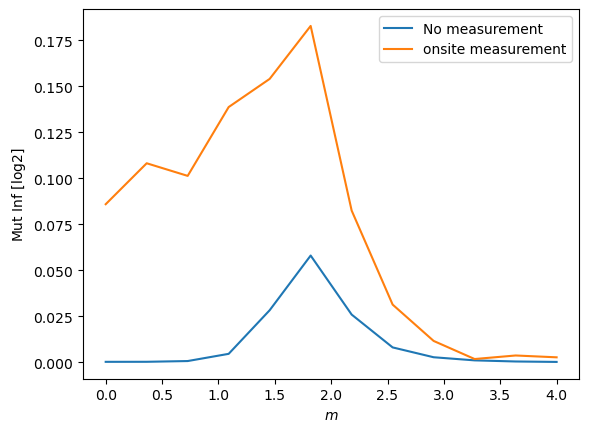

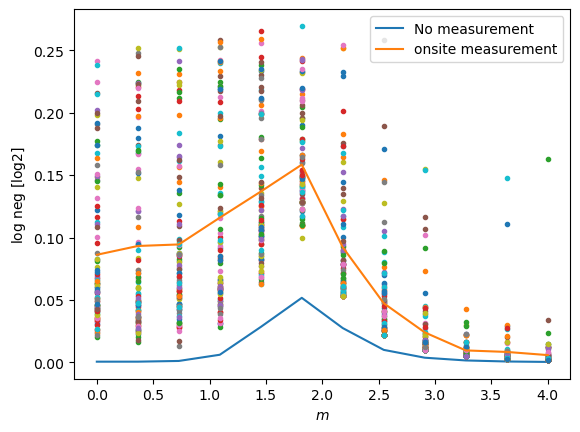

PyObject Text(0.5, 24.0, '$ m $')

In [28]:
plot(mlist,MI/log(2)/Lx,label="No measurement")
# plot(mlist,mean(MI2,dims=2)/log(2),label="link measurement")
plot(mlist,mean(MI3,dims=2)/log(2)/Lx,label="onsite measurement")

legend()
ylabel("Mut Inf \$ [\\log 2 ]\$")
xlabel("\$ m \$")

# plt.savefig("MI_vs_delta_64_32_32.pdf")
plt.show()

plt.figure()
plot(mlist,LN/log(2)/Lx,label="No measurement")
# plot(mlist,mean(LN2,dims=2)/log(2),label="link measurement")
plot(mlist,LN3/log(2)/Lx,".")
plot(mlist,mean(LN3,dims=2)/log(2)/Lx,label="onsite measurement")
# grid()

legend()
ylabel("log neg \$ [\\log 2 ]\$")
xlabel("\$ m \$")

# plt.savefig("SSH_LN_vs_delta_64_32_32.pdf")

# area law check

In [88]:
t = 1
Δ = 0.5
Lxlist = vcat(4:2:12,16:8:32)
Ly = 64
px= 1
py= 1
fparity = 0

m = 0.0

Nrep = 10
LN= zeros(length(Lxlist))
LN2= zeros(length(Lxlist),Nrep)
LN3= zeros(length(Lxlist),Nrep)
MI= zeros(length(Lxlist))
MI3= zeros(length(Lxlist),Nrep)


n_occ = zeros(Nrep)
for i_n=1:length(Lxlist)
    println(i_n)
    Lx = Lxlist[i_n]
    
    χ = 2 
    N = Lx*Ly
    i_names = map(i -> Meta.parse("idx$i"), 1:N)
    i_sizes = fill(χ, N)
    psi = BlockMatrix(i_names, i_sizes)

    l1 = Lx*div(Ly,4)
    l2 = l1
    dist = Lx*div(Ly,4)

    x_sign=diagm(0=> (-1).^mod.(0:Lx*Ly-1,Lx))
    y_sign=diagm(0=> (-1).^div.((0:Lx*Ly-1),Lx))
    H_x= t* y_sign*hopp_vec(Lx,Ly,[1,0],px,py)
    H_y= t* hopp_vec(Lx,Ly,[0,1],px,py)
    H_xy_nn=-im*Δ* y_sign*hopp_vec(Lx,Ly,[1,1],px,py)
    H_Mxy_nn=im*Δ* y_sign*hopp_vec(Lx,Ly,[-1,1],px,py)
    Hhop = H_x+H_y+H_xy_nn+H_Mxy_nn
    Hhop = Hhop+ Hhop'
    H = Hhop + m*y_sign*x_sign

    evals,evecs = eigen(H)
    Cmat = evecs[:,1:div(N,2)]  * evecs[:,1:div(N,2)]'
    CmatT = transpose(Cmat)
    Gmat = kron(I- Cmat-CmatT,[0 1.0;-1.0 0])+ im*kron(Cmat-CmatT,[1.0 0;0 1.0])

    psi[i_names,i_names] = real(Gmat)
    
    MI[i_n] = mutual_information(psi, i_names[1:l1], i_names[l1+dist+1:l1+l2+dist])
    LN[i_n] = logneg_of_sites(psi, i_names[1:l1], i_names[l1+dist+1:l1+l2+dist])

    s1=0

    for i_r= 1:Nrep
        psi3, f3 = measure_onsite(psi,s1+l1+1,s1+l1+dist,2)
#         while f3!=fparity
#             psi3, f3 = measure_onsite(psi,s1+l1+1,s1+l1+dist,2)
#         end
        n_occ[i_r]= f3
#         LN3[i_n,i_r] = logneg_of_sites(psi3, i_names[s1+1:s1+l1], i_names[s1+l1+dist+1:s1+l1+l2+dist])
#         MI3[i_n,i_r] = mutual_information(psi3, i_names[s1+1:s1+l1], i_names[s1+l1+dist+1:s1+l1+l2+dist])

        LN2[i_n,i_r] = logneg_of_sites_stable(psi3, i_names[s1+1:s1+l1], i_names[s1+l1+dist+1:s1+l1+l2+dist])

    end
end

1
2
3
4
5
6
7
8


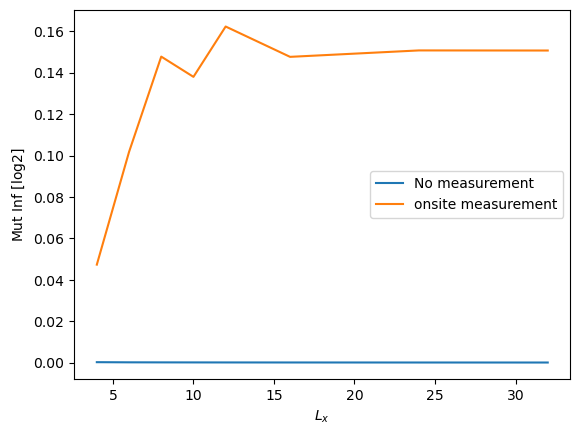

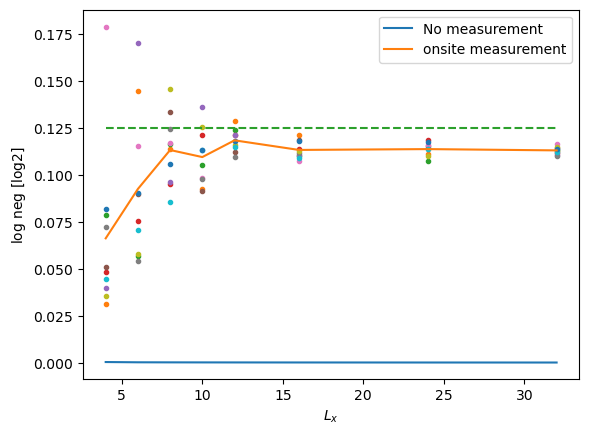

PyObject Text(0.5, 26.4, '$ L_x $')

In [62]:
plot(Lxlist,MI/log(2)./Lxlist,label="No measurement")
plot(Lxlist,mean(MI3,dims=2)/log(2)./Lxlist,label="onsite measurement")

legend()
ylabel("Mut Inf \$ [\\log 2 ]\$")
xlabel("\$ L_x \$")

# plt.savefig("MI_vs_delta_64_32_32.pdf")
plt.show()

plt.figure()
plot(Lxlist,LN/log(2)./Lxlist,label="No measurement")
plot(Lxlist,LN3/log(2)./Lxlist,".")
plot(Lxlist,mean(LN3,dims=2)/log(2)./Lxlist,label="onsite measurement")
plot(Lxlist,Lxlist*0 .+ 1/8,"--")
# grid()

legend()
ylabel("log neg \$ [\\log 2 ]\$")
xlabel("\$ L_x \$")

# plt.savefig("SSH_LN_vs_delta_64_32_32.pdf")

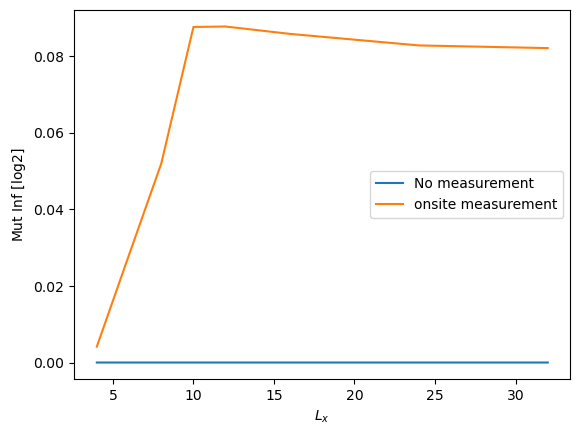

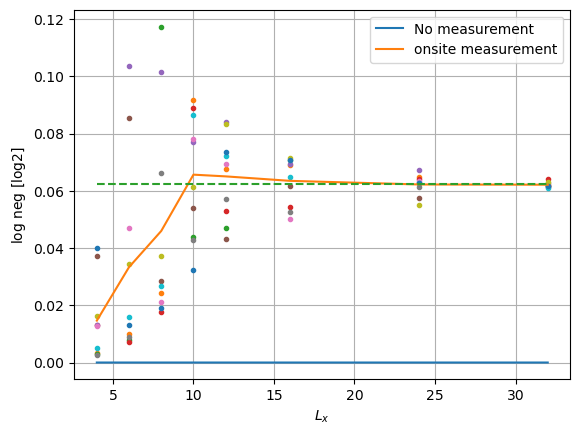

PyObject Text(0.5, 26.4, '$ L_x $')

In [59]:
plot(Lxlist,MI/log(2)./Lxlist,label="No measurement")
plot(Lxlist,mean(MI3,dims=2)/log(2)./Lxlist,label="onsite measurement")

legend()
ylabel("Mut Inf \$ [\\log 2 ]\$")
xlabel("\$ L_x \$")

# plt.savefig("MI_vs_delta_64_32_32.pdf")
plt.show()

plt.figure()
plot(Lxlist,LN/log(2)./Lxlist,label="No measurement")
plot(Lxlist,LN3/log(2)./Lxlist,".")
plot(Lxlist,mean(LN3,dims=2)/log(2)./Lxlist,label="onsite measurement")
plot(Lxlist,Lxlist*0 .+ 1/16,"--")
grid()

legend()
ylabel("log neg \$ [\\log 2 ]\$")
xlabel("\$ L_x \$")

# plt.savefig("SSH_LN_vs_delta_64_32_32.pdf")

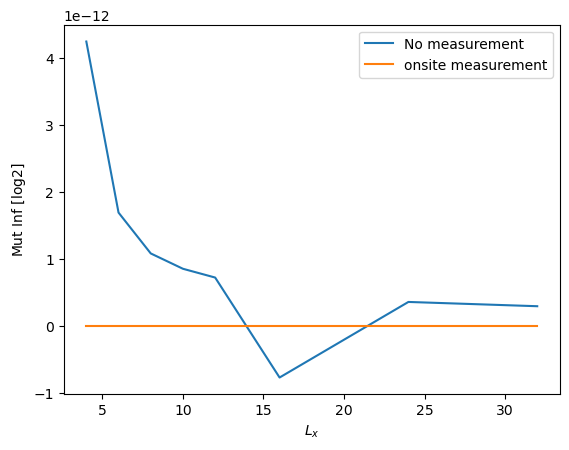

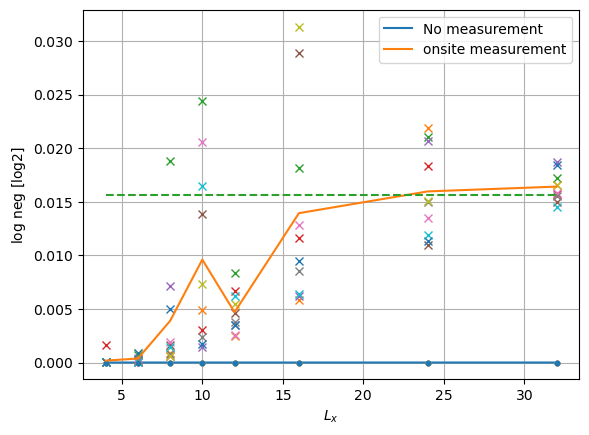

PyObject Text(0.5, 26.4, '$ L_x $')

In [90]:
plot(Lxlist,MI/log(2)./Lxlist,label="No measurement")
plot(Lxlist,mean(MI3,dims=2)/log(2)./Lxlist,label="onsite measurement")

legend()
ylabel("Mut Inf \$ [\\log 2 ]\$")
xlabel("\$ L_x \$")

# plt.savefig("MI_vs_delta_64_32_32.pdf")

figure()
plot(Lxlist,LN/log(2)./Lxlist,label="No measurement")
plot(Lxlist,LN2/log(2)./Lxlist,"x")
plot(Lxlist,LN3/log(2)./Lxlist,".")
plot(Lxlist,mean(LN2,dims=2)/log(2)./Lxlist,label="onsite measurement")
plot(Lxlist,Lxlist*0 .+ 1/64,"--")
grid()

legend()
ylabel("log neg \$ [\\log 2 ]\$")
xlabel("\$ L_x \$")

# plt.savefig("SSH_LN_vs_delta_64_32_32.pdf")

# distance dependence

In [ ]:
t = 1
Δ = 0.5
Lx = 16
Ly = 64
px= 1
py= 1
fparity = 0

m = 0.0

χ = 2 
N = Lx*Ly
i_names = map(i -> Meta.parse("idx$i"), 1:N)
i_sizes = fill(χ, N)
psi = BlockMatrix(i_names, i_sizes)

x_sign=diagm(0=> (-1).^mod.(0:Lx*Ly-1,Lx))
y_sign=diagm(0=> (-1).^div.((0:Lx*Ly-1),Lx))
H_x= t* y_sign*hopp_vec(Lx,Ly,[1,0],px,py)
H_y= t* hopp_vec(Lx,Ly,[0,1],px,py)
H_xy_nn=-im*Δ* y_sign*hopp_vec(Lx,Ly,[1,1],px,py)
H_Mxy_nn=im*Δ* y_sign*hopp_vec(Lx,Ly,[-1,1],px,py)
Hhop = H_x+H_y+H_xy_nn+H_Mxy_nn
Hhop = Hhop+ Hhop'
H = Hhop + m*y_sign*x_sign

evals,evecs = eigen(H)
Cmat = evecs[:,1:div(N,2)]  * evecs[:,1:div(N,2)]'
CmatT = transpose(Cmat)
Gmat = kron(I- Cmat-CmatT,[0 1.0;-1.0 0])+ im*kron(Cmat-CmatT,[1.0 0;0 1.0])

psi[i_names,i_names] = real(Gmat)

l1 = Lx*div(Ly,4)
l2 = l1
dlist = 2:2:div(Ly,4)

Nrep = 10
LN= zeros(length(dlist))
LN2= zeros(length(dlist),Nrep)
LN3= zeros(length(dlist),Nrep)
MI= zeros(length(dlist))
MI3= zeros(length(dlist),Nrep)


n_occ = zeros(Nrep)
for i_n=1:length(dlist)
    println(round(i_n/length(dlist)*100,digits=0))
    
    dist = Lx*dlist[i_n]
   
    MI[i_n] = mutual_information(psi, i_names[1:l1], i_names[l1+dist+1:l1+l2+dist])
    LN[i_n] = logneg_of_sites(psi, i_names[1:l1], i_names[l1+dist+1:l1+l2+dist])

    s1=0

    for i_r= 1:Nrep
        psi3, f3 = measure_onsite(psi,s1+l1+1,s1+l1+dist,2)
#         while f3!=fparity
#             psi3, f3 = measure_onsite(psi,s1+l1+1,s1+l1+dist,2)
#         end
        n_occ[i_r]= f3
#         LN3[i_n,i_r] = logneg_of_sites(psi3, i_names[s1+1:s1+l1], i_names[s1+l1+dist+1:s1+l1+l2+dist])
#         MI3[i_n,i_r] = mutual_information(psi3, i_names[s1+1:s1+l1], i_names[s1+l1+dist+1:s1+l1+l2+dist])

        LN2[i_n,i_r] = logneg_of_sites_stable(psi3, i_names[s1+1:s1+l1], i_names[s1+l1+dist+1:s1+l1+l2+dist])

    end
end

12.0
25.0
38.0
50.0
62.0
75.0
88.0
100.0


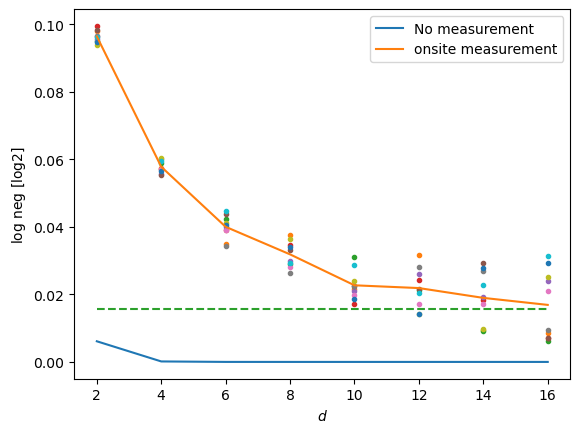

PyObject Text(0.5, 25.0, '$ d $')

In [111]:
# plot(dlist,MI/log(2)./Lx,label="No measurement")
# plot(dlist,mean(MI3,dims=2)/log(2)./Lx,label="onsite measurement")

# legend()
# ylabel("Mut Inf \$ [\\log 2 ]\$")
# xlabel("\$ d \$")

# # plt.savefig("MI_vs_delta_64_32_32.pdf")
# plt.show()

figure()
plot(dlist,LN/log(2)./Lx,label="No measurement")
plot(dlist,LN2/log(2)./Lx,".")
plot(dlist,mean(LN2,dims=2)/log(2)./Lx,label="onsite measurement")
plot(dlist,zeros(length(dlist)) .+ 1/Ly ,"--")
# grid()

legend()
ylabel("log neg \$ [\\log 2 ]\$")
xlabel("\$ d \$")

# plt.savefig("SSH_LN_vs_delta_64_32_32.pdf")